

# Gator Vision


Image Preperation

---

https://www.bannerbear.com/blog/how-to-extract-images-from-a-video-using-ffmpeg/

For linux use:

ffmpeg -i "filename" -vf fps=1 %03d.png

Statue descriptions:
https://localwiki.org/sfsu/Public_Art_Collection

# Setup

---


Import TensorFlow and other necessary libraries:


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# Importing Dataset


---



In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Importing Images on Local Machine

---


In [5]:
import pathlib
data_dir = './SFSU_Art'
data_dir = pathlib.Path(data_dir)
print(data_dir)


SFSU_Art


# Load Data


In [6]:
batch_size = 32
img_height = 256
img_width = 256

# Training data  
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names



Found 188 files belonging to 6 classes.
Using 151 files for training.
Found 188 files belonging to 6 classes.
Using 37 files for validation.


2023-05-11 13:31:52.045052: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-11 13:31:52.045370: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-11 13:31:52.045396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emanuelf-thinkpad-x1): /proc/driver/nvidia/version does not exist
2023-05-11 13:31:52.046858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#Display the different class names 
print(class_names)

#Display 1 an image from the categories
gator = list(data_dir.glob('Gator_Spirit/*'))
PIL.Image.open(str(gator[5]))


# Create a Dataset

According to TensorFlow it is a good practice to use 80% of the images for training and 20% for validation.

In [7]:
#Setting some parameters for the loader
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 188 files belonging to 6 classes.
Using 151 files for training.
Found 188 files belonging to 6 classes.
Using 37 files for validation.


In [ ]:
#View first 9 images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [8]:
#Performance Tuning 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



# Standardize the data

---
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [9]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


# Basic Keras model

The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


# Compile the model

For this tutorial, choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

# Training the Model
---

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


# Visualize training results
---
Create plots of the loss and accuracy on the training and validation sets:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Data Augmentation
---


In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


# Dropout

In [13]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


# Re-compile

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [15]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15


2023-05-11 13:32:42.183552: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2023-05-11 13:32:43.246670: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.


1/5 [=====>........................] - ETA: 21s - loss: 1.7913 - accuracy: 0.2500

2023-05-11 13:32:43.729785: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2023-05-11 13:32:44.738858: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.


2/5 [===========>..................] - ETA: 4s - loss: 3.4210 - accuracy: 0.3125 

2023-05-11 13:32:45.200438: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.


5/5 [==============================] - 12s 2s/step - loss: 3.1146 - accuracy: 0.1854 - val_loss: 2.1550 - val_accuracy: 0.2162
Epoch 2/15
5/5 [==============================] - 7s 1s/step - loss: 1.5438 - accuracy: 0.4371 - val_loss: 1.2916 - val_accuracy: 0.5405
Epoch 3/15
5/5 [==============================] - 7s 1s/step - loss: 1.1677 - accuracy: 0.6623 - val_loss: 0.9629 - val_accuracy: 0.6757
Epoch 4/15
5/5 [==============================] - 7s 1s/step - loss: 0.7290 - accuracy: 0.7682 - val_loss: 0.5278 - val_accuracy: 0.7838
Epoch 5/15
5/5 [==============================] - 7s 1s/step - loss: 0.4184 - accuracy: 0.8874 - val_loss: 0.4248 - val_accuracy: 0.7838
Epoch 6/15
5/5 [==============================] - 7s 1s/step - loss: 0.2398 - accuracy: 0.9073 - val_loss: 0.2969 - val_accuracy: 0.9459
Epoch 7/15
5/5 [==============================] - 7s 2s/step - loss: 0.1854 - accuracy: 0.9338 - val_loss: 0.4557 - val_accuracy: 0.7568
Epoch 8/15
5/5 [==============================] - 7

# Visualize training results
---


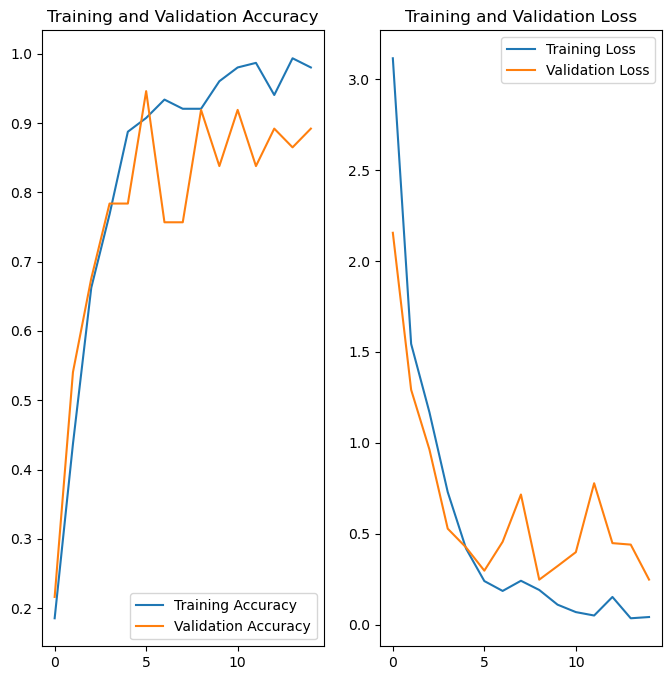

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Convert to TensorFlow Lite


---


In [17]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmp_8crxo0x/assets


INFO:tensorflow:Assets written to: /tmp/tmp_8crxo0x/assets
2023-05-11 13:35:40.055860: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-05-11 13:35:40.055903: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-05-11 13:35:40.057140: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_8crxo0x
2023-05-11 13:35:40.073219: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-11 13:35:40.073282: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_8crxo0x
2023-05-11 13:35:40.126901: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-05-11 13:35:40.144143: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-05-11 13:35:40.348924: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

# Run the TensorFlow Lite model
---
You can access the TensorFlow Lite saved model signatures in Python via the tf.lite.Interpreter class.

Load the model with the Interpreter:

In [22]:

TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
model.export(export_dir='.', export_format=ExportFormat.LABEL)


interpreter.get_signature_list()


AttributeError: 'Sequential' object has no attribute 'export'